In the terminal: `cd ..` to be in the `_shared_utils` sub-folder, run `make setup_env`, then `cd` back into your task sub-folder (e.g., `bus_service_increase` or `example_report`)

In [1]:
import geopandas as gpd
import os
import pandas as pd

#os.environ["CALITP_BQ_MAX_BYTES"] = str(70_000_000_000)

import calitp
from calitp.tables import tbl
from siuba import *

from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Aggregation

In [2]:
TABULAR_DATA = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/taxis.csv"
df = pd.read_csv(TABULAR_DATA)
df.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


In [3]:
group_cols = ["pickup_borough", "payment"]
sum_cols = ["tip", "tolls"]
mean_cols = ["fare"]
count_cols = ["pickup"]
nunique_cols = ["pickup_zone"]

by_borough = geography_utils.aggregate_by_geography(
    df[df.pickup_borough.notna()], 
    group_cols=group_cols,
    sum_cols = sum_cols,
    mean_cols = mean_cols,
    count_cols = count_cols,
    nunique_cols = nunique_cols
)

by_borough

,pickup_borough,payment,tip,tolls,fare,pickup,pickup_zone
0,Manhattan,credit card,10217.55,643.42,11.480182,3839.0,60.0
1,Manhattan,cash,0.00,103.68,10.273085,1397.0,63.0
2,Manhattan,NaN,NaN,NaN,NaN,NaN,NaN
3,Queens,cash,0.00,235.97,19.069549,266.0,24.0
4,Queens,credit card,1997.32,881.63,29.237755,383.0,46.0
5,Bronx,credit card,14.71,77.04,24.904189,74.0,33.0
6,Brooklyn,credit card,370.11,109.44,18.875402,261.0,48.0
7,Brooklyn,cash,0.00,0.00,11.100840,119.0,28.0
8,Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN
9,Queens,NaN,NaN,NaN,NaN,NaN,NaN


## Merging geometry back on after aggregation

In [4]:
GEOSPATIAL_DATA = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON"
gdf = (gpd.read_file(GEOSPATIAL_DATA)
       .rename(columns = {"boro_name": "pickup_borough"})
      )
gdf

,boro_code,pickup_borough,shape_area,shape_leng,geometry
0,1,Manhattan,636620785.656,359993.127161,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
1,2,Bronx,1187193544.78,463868.935588,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,3,Brooklyn,1934174207.47,728195.194837,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
3,5,Staten Island,1623631283.35,325924.002252,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
4,4,Queens,3040205596.49,900269.281914,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [5]:
by_borough2 = geography_utils.attach_geometry(
    by_borough,
    gdf,
    merge_col = "pickup_borough",
    join = "inner"
)

print(f"# obs in original df: {len(by_borough)}")
print(f"# obs in merged df: {len(by_borough2)}")

# obs in original df: 11
# obs in merged df: 11


In [6]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/"
FILE_NAME = "test_geoparquet"
utils.geoparquet_gcs_export(by_borough2, GCS_FILE_PATH, FILE_NAME)

/home/jovyan/data-analyses/_shared_utils/shared_utils/utils.py:34: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_parquet(f"./{FILE_NAME}.parquet")


## Find routes for operator

In [7]:
ITP_ID_LIST = [
    278, # SD 
    323, # Metrolink
]

routes = geography_utils.make_routes_shapefile(
    ITP_ID_LIST, 
    CRS = geography_utils.CA_NAD83Albers
)

print(f"CRS: {routes.crs}")
routes.head()

CRS: EPSG:3310


,calitp_itp_id,shape_id,calitp_extracted_at,geometry
0,278,105_0_98,2021-11-24,"LINESTRING (262789.129 -580315.385, 262797.154..."
1,278,105_0_99,2021-11-24,"LINESTRING (262789.129 -580315.385, 262797.154..."
2,278,105_1_100,2021-11-24,"LINESTRING (261900.734 -572127.267, 261898.566..."
3,278,105_1_101,2021-11-24,"LINESTRING (262438.937 -574058.570, 262439.559..."
4,278,105_1_97,2021-11-24,"LINESTRING (261045.606 -567692.018, 261045.447..."


In [8]:
ITP_ID_LIST = [
    37, # Bellflower Bus
]

routes = geography_utils.make_routes_shapefile(
    ITP_ID_LIST, 
    CRS = geography_utils.CA_StatePlane
)

print(f"CRS: {routes.crs}")
routes.head()

CRS: EPSG:2229


,calitp_itp_id,shape_id,calitp_extracted_at,geometry
0,37,p_901781,2021-06-24,"LINESTRING (6523644.007 1780962.385, 6523645.0..."
1,37,p_901783,2021-06-24,"LINESTRING (6523644.007 1780962.385, 6523645.0..."
2,37,p_901785,2021-06-24,"LINESTRING (6524557.567 1779950.643, 6524557.2..."
3,37,p_901786,2021-06-24,"LINESTRING (6524557.567 1779950.643, 6524557.2..."


<AxesSubplot:>

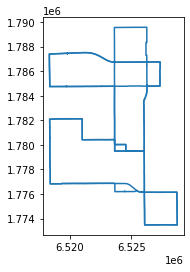

In [9]:
routes.plot()